# Computational Finance
## Lab Assignment 1
### Adrian + Daan + Menno 

In [7]:
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

### 1. Option Valuation using Binomial Trees

We are trying to provide the risk-free fair price for an Option Call, a financial derivative that gives the option holder the right to buy an underlying security at one or many future events.

We assume:

- A two state economy, the price of the underlying can go up or down
- Money can be invested risk free for a constant interest rate
- There is no arbitrage or transaction costs

In [77]:
def binomialTree(S, sigma, T, N, r, K, option_type='Call', origin = 'European'):
    # Time step
    dt = T / N

    # Possible price movements
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))

    # Matrix that will hold the values
    matrix = tree = np.zeros((N + 1, N + 1))

    matrix[0, 0] = S

    # Populate the matrix with the stock price progression
    for i in np.arange(1, N + 1): # iterate over rows
        for j in np.arange(i + 1): # iterate over columns
            if j == 0:
                matrix[i, j] = matrix[i-1, j] * d
            else:
                matrix[i, j] = matrix[i-1, j-1] * u

    # Price at each step
    p = (np.exp(r*dt) - d) / (u - d)

    # Hedge amount at each step
    # delta = (up - down) / (s * u - s * d)

    columns = tree.shape[1] 
    rows = tree.shape[0]

    # Calculate the price for the expiration day nodes
    for c in np.arange(columns):
        S = tree[rows - 1, c] # Value in the matrix
        if option_type == 'Call':
            tree[rows - 1, c] =  max(0, S - K) 
        else: 
            tree[rows - 1, c] =  max(0, K - S) # Put option

    # Backwards Induction through the nodes
    for i in np.arange(rows - 1)[:: -1]:
        for j in np.arange(i + 1):
            down = tree[i + 1, j]
            up = tree[i + 1, j + 1]
            if origin == "European":
                tree[i, j] = np.exp(-r*dt) * (p * up + (1-p) * down)

            elif origin == 'American':
                tree[i, j] = max(tree[i, j] - K, np.exp(-r*dt) * (p * up + (1-p) * down))
    
    return tree[0][0]

In [1]:
def blackSholes(S, K, t, r, sigma, option_type='Call'):
    # Time to maturity
    tau = T - t

    # Parameters
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)

    # Hedge amount at t
    delta = norm.cdf(d1)

    if option_type == 'Call':
        call_price = S * norm.cdf(d1) - np.exp(-r*tau) * K * norm.cdf(d2)
        return call_price, delta
    else:
        put_price = (np.exp(-r*tau) * K * norm.cdf(-d2)) - (S * norm.cdf(-d1))
        return put_price, delta

In [97]:
# Option Parameters
S = S0 = 100 # Starting stock price
K = 99 # Strike price
T = 1 # Time of maturity
t = 0 # Current period
N = 50 # Amount of steps, possible price changes
r = 0.06 # Risk free interest rate
sigma = vol = 0.2 # Volatility of the stock

In [80]:
test_bt = binomialTree(S, sigma, T, N, r, K)
print(test_bt)

test_bs = blackSholes(S, K, t, r, sigma)
print(test_bs[0])

11.546434850755034
11.544280227051097


In [84]:
def plot_errors(max_steps=500):
    bs_price = blackSholes(S, K, t, r, sigma)[0]
    errors = []
    steps = []

    for N in range(30, max_steps, 5):
        errors.append(abs(bs_price-binomialTree(S, sigma, T, N, r, K)))
        steps.append(N)
    plt.plot(steps,errors)
    plt.xlabel('Step')
    plt.ylabel('Error')

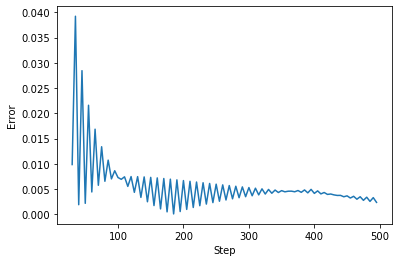

In [85]:
plot_errors()

In [86]:
def plot_difference(max_steps=10):
    bs_price = bs_price = blackSholes(S, K, t, r, sigma)[0]
    tree_price = []
    steps = []
    for N in range(30, max_steps, 5):
        tree_price.append(binomialTree(S, sigma, T, N, r, K))
        steps.append(N)
    plt.plot(steps,tree_price,label='Binomial Tree')
    plt.xlabel('Steps')
    plt.ylabel('Option Price')
    plt.plot([steps[0],steps[-1]],[bs_price,bs_price],color='Black',label='Black Sholes')
    plt.legend()

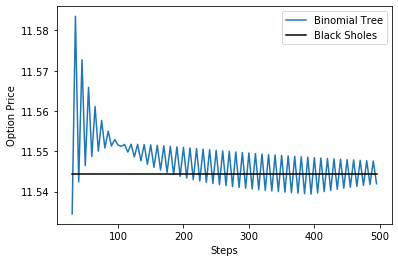

In [87]:
plot_difference()

In [151]:
def plot_volatility():
    sigmas = []
    hedges = []
    for sigma in np.linspace(0,1,44):
        hedges.append(blackSholes(S, K, t, r, sigma)[1])
        sigmas.append(sigma)
    plt.plot(sigmas, hedges)
    plt.xlabel('Volatility')
    plt.ylabel('Hedge')

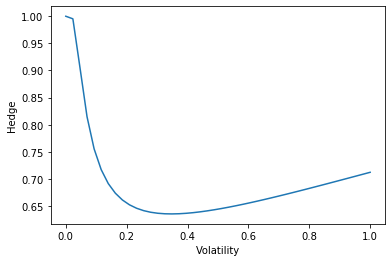

In [152]:
plot_volatility()

In [153]:
def plot_variety():
    a_put = []
    a_call = []
    e_put = []
    e_call = []
    sigmas = []
    for sigma in np.linspace(0,1,11):
        a_put.append(binomialTree(S, sigma, T, N, r, K,option_type='Put', origin = 'American'))
        a_call.append(binomialTree(S, sigma, T, N, r, K,option_type='Call', origin = 'American'))
        e_put.append(binomialTree(S, sigma, T, N, r, K,option_type='Put', origin = 'European'))
        e_call.append(binomialTree(S, sigma, T, N, r, K,option_type='Call', origin = 'European'))
        sigmas.append(sigma)
    plt.plot(sigmas,a_put, label='American Put')
    plt.plot(sigmas,a_call, label='American Call')
    plt.plot(sigmas,e_put, label='European Put')
    plt.plot(sigmas,e_call, label='European Call')
    plt.xlabel('Volatility')
    plt.ylabel('Option Price')
    plt.legend()


In [154]:
# Option Parameters
S = S0 = 100 # Starting stock price
K = 99 # Strike price
T = 1 # Time of maturity
t = 0 # Current period
N = 100 # Amount of steps, possible price changes
r = 0.05 # Risk free interest rate

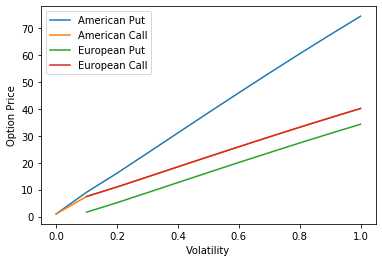

In [155]:
plot_variety()

## 2. Black-Scholes model: hedging simulations

Use  the  Euler  method  to  perform  a  hedging  simulation.   Do  an  experiment  where  the volatility in the stock price process is matching the volatility used in the delta computation(set both equal to 20%). Vary the frequency of the hedge adjustment (from daily to weekly)and explain the results.  Perform numerical experiments where the volatility in the stockprice process is not matching the volatility used in the delta valuation.  Experiment forvarious levels and explain the results.


In [36]:
# Parameter
sigma = 0.2 # Volatility of the stock price
r = 0.06 # Risk free interest rate
S = 100 # Starting stock price
K = 99 # Strike price
T = 1 # Time of maturity
M = 10 # aMount of periods in between option sale and maturity

In [270]:

# Parameter
sigma = 0.2 # Volatility of the stock price
r = 0.06 # Risk free interest rate
S = 100 # Starting stock price
K = 99 # Strike price
T = 1 # Time of maturity
M = 50 # aMount of periods in between option sale and maturity

S0 = S

dt = T/M
t = 0
tau = T - t

all_S = [S0]
all_m = [0]
all_delta = [norm.cdf((np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau)))]


option_price = blackSholes(S, K, t, r, sigma)[0]
print(option_price, all_delta[0], S)
wallet = option_price
holdings = all_delta[0]
wallet -= (all_delta[0]*all_S[0])

all_holdings = [holdings]
all_wallet = [wallet]
print('H: ',holdings, 'W: ',wallet, 'S: ', S)
for m in range(M):
        # Sample random value
        z = np.random.normal(0, 1)

        # Stock price calculation
        current_S = all_S[-1]
        S = current_S + r*current_S*dt + sigma * current_S * np.sqrt(dt) * z

        # Hedge
        tau -= dt
        d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
        delta = norm.cdf(d1)

        if np.isnan(delta):
            if all_delta[-1]>0.9:
                delta =1
            else:
                delta =0 
        all_delta.append(delta)

        difference = holdings-delta
        holdings = delta
        
        wallet *= np.exp(r*(dt))
        wallet += difference * S
        
        all_S.append(S)
        all_m.append(m)
        print('H: ',holdings, 'W: ',wallet, 'S: ', S, 'tau: ', tau)

if S > K:
    print('cashed')
    wallet += K
    holdings -= 1
print('H: ',holdings, 'W :',wallet, 'Int: ',(option_price*(np.exp(r))-option_price))
print(wallet-(option_price*(np.exp(r))-option_price))

11.544280227051097 0.6737355117348961 100
H:  0.6737355117348961 W:  -55.82927094643852 S:  100
H:  0.7568577960078273 W:  -64.6294379603354 S:  105.06366315592653 tau:  0.98
H:  0.6680235226297184 W:  -55.83882131696731 S:  99.82879561572497 tau:  0.96
H:  0.7208343195720681 W:  -61.33825351373775 S:  102.86505233167618 tau:  0.94
H:  0.824215276218276 W:  -72.78087118643633 S:  109.97158428486915 tau:  0.9199999999999999
H:  0.8288875678383523 W:  -73.38367817628878 S:  110.3136454538942 tau:  0.8999999999999999
H:  0.8322499877768681 W:  -73.84348634819818 S:  110.5438664727894 tau:  0.8799999999999999
H:  0.8297671037773837 W:  -73.65831245680721 S:  110.2908003954867 tau:  0.8599999999999999
H:  0.7964936770565855 W:  -70.16120652340733 S:  107.76013524665764 tau:  0.8399999999999999
H:  0.7569703406534831 W:  -66.08836717497479 S:  105.18047591284618 tau:  0.8199999999999998
H:  0.766495345992143 W:  -67.17514628985613 S:  105.76639443118509 tau:  0.7999999999999998
H:  0.8597327

In [356]:
all_differences = []
all_2 = []
from tqdm import tqdm
for num in tqdm(range(5000)):
    error = 1.5

    # Parameter
    sigma = 0.2 # Volatility of the stock price
    r = 0.06 # Risk free interest rate
    S = 100 # Starting stock price
    K = 99 # Strike price
    T = 1 # Time of maturity
    M = 200 # aMount of periods in between option sale and maturity

    S0 = S

    dt = T/M
    t = 0
    tau = T - t

    all_S = [S0]
    all_m = [0]
    all_delta = [norm.cdf((np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau)))]
    all_delta2 = [norm.cdf((np.log(S/K) + (r + 0.5 * (sigma*error)**2) * tau) / ((sigma*error) * np.sqrt(tau)))]


    option_price = blackSholes(S, K, t, r, sigma)[0]
    # print(option_price, all_delta[0], S)
    wallet = option_price
    holdings = all_delta[0]
    wallet -= (all_delta[0]*all_S[0])

    wallet2 = option_price
    holdings2 = all_delta[0]
    wallet2 -= (all_delta[0]*all_S[0])

    all_holdings = [holdings]
    all_wallet = [wallet]
    # print('H: ',holdings, 'W: ',wallet, 'S: ', S)
    for m in range(M):
            # Sample random value
            z = np.random.normal(0, 1)

            # Stock price calculation
            current_S = all_S[-1]
            S = current_S + r*current_S*dt + sigma * current_S * np.sqrt(dt) * z

            # Hedge
            tau -= dt
            d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
            delta = norm.cdf(d1)

            d12 = (np.log(S/K) + (r + 0.5 * ((sigma*error)**2)) * tau) / ((sigma*error) * np.sqrt(tau))
            delta2 = norm.cdf(d12)

            if np.isnan(delta):
                if all_delta[-1]>0.8:
                    delta =1
                else:
                    delta =0 

            if np.isnan(delta2):
                if all_delta2[-1]>0.8:
                    delta2 =1
                else:
                    delta2 =0 
            all_delta.append(delta)
            all_delta2.append(delta2)



            difference = holdings-delta
            holdings = delta
            wallet += difference * S
            wallet *= np.exp(r*dt)
            all_S.append(S)
            all_m.append(m)

            difference2 = holdings2-delta2
            holdings2 = delta2
            wallet2 += difference2 * S
            wallet2 *= np.exp(r*dt)
            # print('H: ',holdings, 'W: ',wallet, 'S: ', S, 'tau: ', tau)
    # print(K, S)
    if S > K:
        # print('cashed')
        if holdings != 1:
            # print('H0000: ',holdings, 'W: ',wallet, 'S: ', S, 'tau: ', tau)
            dif = 1 - holdings
            wallet -= dif * S
            holdings += 1
            # print(holdings == 1, wallet)
        wallet += K
        holdings -= 1
        if holdings2 != 1:
            dif2 = 1 - holdings2
            wallet2 -= dif2 * S
            holdings2 += 1
            # print(holdings2 == 1, wallet2)
        wallet2 += K
        holdings2 -= 1
    # print('H: ',holdings, 'W :',wallet, 'Int: ',(option_price*(np.exp(r))-option_price))
    all_differences.append(wallet)
    all_2.append(wallet2)
    if abs(all_differences[-1])> 3:
        pass
        # print('H111: ',holdings, 'W: ',wallet, 'S: ', S, 'tau: ', tau)
    # print(wallet-(option_price*(np.exp(r))-option_price))

51<00:52, 10.98it/s]


 88%|████████▊ | 4423/5000 [05:51<00:48, 11.95it/s]


 88%|████████▊ | 4425/5000 [05:51<00:42, 13.45it/s]


 89%|████████▊ | 4427/5000 [05:51<00:40, 14.06it/s]


 89%|████████▊ | 4429/5000 [05:52<00:44, 12.89it/s]


 89%|████████▊ | 4431/5000 [05:52<00:46, 12.36it/s]


 89%|████████▊ | 4433/5000 [05:52<00:48, 11.75it/s]


 89%|████████▊ | 4435/5000 [05:52<00:42, 13.24it/s]


 89%|████████▊ | 4437/5000 [05:52<00:39, 14.38it/s]


 89%|████████▉ | 4439/5000 [05:52<00:36, 15.43it/s]


 89%|████████▉ | 4441/5000 [05:52<00:34, 16.21it/s]


 89%|████████▉ | 4443/5000 [05:53<00:34, 16.13it/s]


 89%|████████▉ | 4445/5000 [05:53<00:34, 16.26it/s]


 89%|████████▉ | 4447/5000 [05:53<00:32, 17.06it/s]


 89%|████████▉ | 4449/5000 [05:53<00:32, 17.21it/s]


 89%|████████▉ | 4451/5000 [05:53<00:34, 15.95it/s]


 89%|████████▉ | 4453/5000 [05:53<00:40, 13.50it/s]


 89%|████████▉ | 4455/5000 [05:53<00:44, 12.28it/s]


 89%|████████▉ | 4457/5000 [05:54<00:41, 12.94it/s]


 89%|

In [357]:
final = []
final2 = []
for dif in all_differences:
    if abs(dif) < 10:
        final.append(dif)
for diff in all_2:
    if abs(diff) < 60:
        final2.append(diff)

    
print(np.mean(all_differences), len(final))
print(np.mean(all_2), len(final2))

-0.3880318958209107 4980
-0.17685135691752388 4991


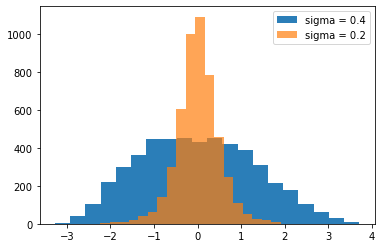

In [359]:
np.mean(all_2)

plt.hist(final2,alpha=0.95,bins=20,label='sigma = 0.4')
plt.hist(final,alpha=0.7,bins=20, label= 'sigma = 0.2')

plt.ylabel='Samples'
plt.xlabel='Profit'

plt.legend()

plt.show()

In [371]:
from tqdm import tqdm
import pickle

volatilities = [0.25, 0.5, 0.75, 1.5, 2, 3]
for vol in volatilities:

    # Output
    profit = []
    profit_2= []

    for iteration in tqdm(range(1000)):

        # Sigma multiplier
        error = vol

        # Parameters
        sigma = 0.2 # Volatility of the stock price
        r = 0.06 # Risk free interest rate
        S = S0 = 100 # Starting stock price
        K = 99 # Strike price
        T = 1 # Time of maturity
        M = 5000 # aMount of periods in between option sale and maturity
        t = 0

        dt = T/M
        tau = T - t

        # Data Collection
        all_S = [S0]
        all_m = [0]
        all_delta = [norm.cdf((np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau)))]
        all_delta2 = [norm.cdf((np.log(S/K) + (r + 0.5 * (sigma*error)**2) * tau) / ((sigma*error) * np.sqrt(tau)))]

        # Money System
        option_price = blackSholes(S, K, t, r, sigma)[0]
        wallet = option_price
        holdings = all_delta[0]
        wallet -= (all_delta[0]*all_S[0])

        wallet2 = option_price
        holdings2 = all_delta[0]
        wallet2 -= (all_delta[0]*all_S[0])

        for m in range(M):

                # Sample random value
                z = np.random.normal(0, 1)

                # Stock price calculation
                current_S = all_S[-1]
                S = current_S + r*current_S*dt + sigma * current_S * np.sqrt(dt) * z

                # Hedge
                tau -= dt
                d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
                delta = norm.cdf(d1)

                d12 = (np.log(S/K) + (r + 0.5 * ((sigma*error)**2)) * tau) / ((sigma*error) * np.sqrt(tau))
                delta2 = norm.cdf(d12)

                # When delta gets really small numpy turns it into a nan
                if np.isnan(delta):
                    if all_delta[-1]>0.8:
                        delta =1
                    else:
                        delta =0

                if np.isnan(delta2):
                    if all_delta2[-1]>0.8:
                        delta2 =1
                    else:
                        delta2 =0

                all_delta.append(delta)
                all_delta2.append(delta2)

                difference = holdings-delta
                holdings = delta
                wallet += difference * S
                wallet *= np.exp(r*dt)

                difference2 = holdings2-delta2
                holdings2 = delta2
                wallet2 += difference2 * S
                wallet2 *= np.exp(r*dt)

                all_S.append(S)
                all_m.append(m)

        if S > K:
            # Cash in the option
            if holdings != 1:
                dif = 1 - holdings
                wallet -= dif * S
                holdings += 1

            wallet += K
            holdings -= 1

            if holdings2 != 1:
                dif2 = 1 - holdings2
                wallet2 -= dif2 * S
                holdings2 += 1

            wallet2 += K
            holdings2 -= 1

        profit.append(wallet)
        profit_2.append(wallet2)
    profit_list = [profit,profit_2]
    with open(str(vol)+'.p', 'wb') as handle:
        pickle.dump(profit_list, handle, protocol=pickle.HIGHEST_PROTOCOL)






  0%|          | 0/10 [00:00<?, ?it/s]



100%|██████████| 10/10 [00:00<00:00, 70.65it/s]




  0%|          | 0/10 [00:00<?, ?it/s]



100%|██████████| 10/10 [00:00<00:00, 67.74it/s]




  0%|          | 0/10 [00:00<?, ?it/s]



 50%|█████     | 5/10 [00:00<00:00, 40.46it/s]



100%|██████████| 10/10 [00:00<00:00, 35.05it/s]




  0%|          | 0/10 [00:00<?, ?it/s]



 50%|█████     | 5/10 [00:00<00:00, 40.67it/s]



100%|██████████| 10/10 [00:00<00:00, 37.90it/s]




  0%|          | 0/10 [00:00<?, ?it/s]



 50%|█████     | 5/10 [00:00<00:00, 48.69it/s]



100%|██████████| 10/10 [00:00<00:00, 46.10it/s]




  0%|          | 0/10 [00:00<?, ?it/s]



 10%|█         | 1/10 [00:00<00:00,  9.54it/s]



 50%|█████     | 5/10 [00:00<00:00, 12.24it/s]



100%|██████████| 10/10 [00:00<00:00, 28.23it/s]


In [ ]:
final = []
final2 = []
for dif in all_differences:
    if abs(dif) < 10:
        final.append(dif)
for diff in all_2:
    if abs(diff) < 60:
        final2.append(diff)

print(np.mean(all_differences), len(final))
print(np.mean(all_2), len(final2))
np.mean(all_2)

plt.hist(final2,alpha=0.95,bins=20,label='sigma = 0.4')
plt.hist(final,alpha=0.7,bins=20, label= 'sigma = 0.2')

plt.ylabel='Samples'
plt.xlabel='Profit'

plt.legend()

plt.show()

In [ ]:
'def gbm_euler(S, K, T, M, sigma, r):
    # Time step
    dt = T / M
    tau = 1

    all_S = [S0]
    all_m = [0]
    all_delta = [norm.cdf((np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau)))]
    # Algorithm 2.2
    for m in range(M):
        # Sample random value
        z = np.random.normal(0, 1)

        # Stock pr'ce calculation
        current_S = all_S[-1]
        S = current_S + r*current_S*dt + sigma * current_S * np.sqrt(dt) * z

        # Hedge
        tau -= dt
        d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
        delta = norm.cdf(d1)
        all_delta.append(delta)

        all_S.append(S)
        all_m.append(m)
    return [all_m, all_S, all_delta]


- At time = 0 we calculate the option price (should be the same for one and two)
- We "borrow the money" -> if option price = 300 then we have 300 euros in bank account we use to buy and sell stock
- at t = 1 we calculate delta_1 (let's say 0.5) -> we buy the stock (0.5 * S) and check that in the balance sheet
- At each time step we calculate difference in hedges, buying and selling stock... at time = T, we should the option price with the accrued interest (300*interest rate) -> any discrepancy with this amount is the error

-> plot the error over many tries and over different sigma values

In [144]:
def gbm_euler_2(S, K, T, M, sigma, r):
    multi = 1.5
    # Time step
    dt = T / M
    tau = 1

    all_S = [S0]
    all_m = [0]
    all_delta = [norm.cdf((np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau)))]
    all_delta_2 = [norm.cdf((np.log(S/K) + (r + 0.5 * (sigma*multi)**2) * tau) / ((sigma*multi) * np.sqrt(tau)))]
    all_error = [all_delta[0]-all_delta_2[0]]
    all_error_abs =  [abs(all_delta[0]-all_delta_2[0])]
    # Algorithm 2.2
    for m in range(M):
        # Sample random value
        z = np.random.normal(0, 1)

        # Stock price calculation
        current_S = all_S[-1]
        S = current_S + r*current_S*dt + sigma * current_S * np.sqrt(dt) * z

        # Hedge
        tau -= dt
        d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
        delta = norm.cdf(d1)
        all_delta.append(delta)

        # S = current_S + r*current_S*dt + (sigma*multi) * current_S * np.sqrt(dt) * z
        d12 = (np.log(S/K) + (r + 0.5 * (sigma*multi)**2) * tau) / ((sigma*multi) * np.sqrt(tau))
        delta_2 =  norm.cdf(d12)
        all_delta_2.append(delta_2)

        all_error.append(delta-delta_2)
        all_error_abs.append(abs(delta-delta_2))

        all_S.append(S)
        all_m.append(m)

    return [all_m, all_S, all_delta, all_error, all_error_abs]

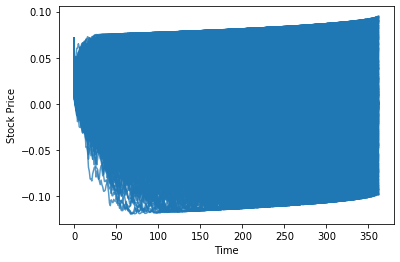

In [150]:
def plot_euler(all_pairs):
    for pair in all_pairs:
        plt.plot(pair[0][0:-2],pair[3][0:-2],color='tab:blue',alpha=0.75)
    
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.show()
plot_euler(all_pairs)

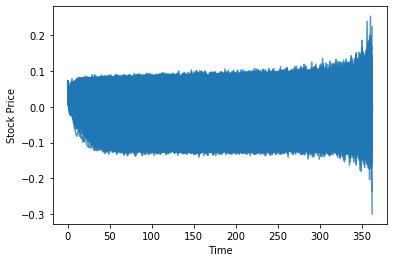

In [132]:
all_pairs = []

for i in range(500):
    all_pairs.append(gbm_euler_2(S, K, T, M, sigma, r))

plot_euler(all_pairs)

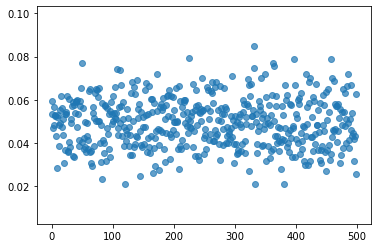

In [149]:
a = range(len(all_pairs))
last = []
for pair in all_pairs:
    last.append(np.mean(pair[4]))
plt.scatter(a,last,alpha=0.7)

In [115]:
len(all_pairs)

100

Text(0, 0.5, 'Stock price')

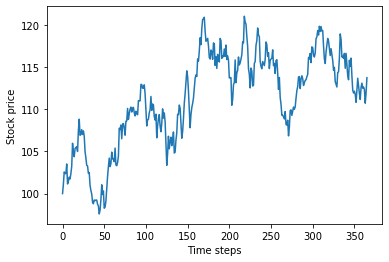

In [71]:
# 2.2
sigma = 0.2
r = 0.06
S0 = 100
K = 99
T = 1
M = 365 # weeks?
dt = T/M

d1s = []
all_S = [S0]
tau = 1
for m in range(M):
    z = np.random.normal(0, 1)
    current_S = all_S[-1]
    S = current_S + r*current_S*dt + sigma * current_S * np.sqrt(dt) * z

    d1 = np.log(S/K) + (r + 0.5 * sigma**2) * tau
    d1 = d1 / (sigma * np.sqrt(tau))

    d1s.append(d1)
    all_S.append(S)
    tau -= dt


plt.plot(range(M + 1), all_S)
plt.xlabel("Time steps")
plt.ylabel("Stock price")